# XGBOOST: Predicción de Readmisión Temprana (<30 días)
- Trabajaremos con el dataset diabetic_data.csv.

- Nuevo Objetivo: Predecir específicamente si un paciente será readmitido en menos de 30 días (clase 1).

- Los pacientes que no son readmitidos o que lo son después de 30 días se considerarán clase 0.

- Esto nos ayuda a identificar los casos más urgentes.

In [1]:
# Importo librerias que se utilizaran
import pandas as pd
import seaborn as sns

# Configuración de estilo de seaborn
sns.set_style("whitegrid")

# Carga de datos
data = pd.read_csv('../data/raw/diabetic_data.csv')

data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [2]:
# Primero eliminaré las filas identificatorias, en este caso son las siguientes: encounter_id, patient_nbr, payer code
import numpy as np
data.drop(['payer_code', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
data.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),?,6,25,1,1,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),?,1,1,7,3,?,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),?,1,1,7,2,?,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),?,1,1,7,1,?,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Ahora detecto que el data set tiene nulos en forma de ' ? ', creare un arreglo para eliminarlos, ya que son nulos
data.isnull().sum()

race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

In [4]:
import numpy as np

data.replace('?', np.nan, inplace=True)
print("Total de valores nulos: ")
data.isnull().sum()

Total de valores nulos: 


race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

Antes de eliminar los valores nulos, primero analizare su importancia para valorar su respectivo manejo.
Primero analizaré las columnas con más nulos:
- **weight (Peso) :** Contiene 98569 esto es mas del 90% de sus valores totales, es decir el total de filas (pacientes) es de 101,7666, por lo que procedere a eliminar la columna directamente, ya que un porcentaje tan alto no es posible rellenar valores, esto nos daria mas ruido.
- **payer_code (Codigo de pagador):** Contiene 40256 valores nulos, debido a la naturaleza de la variable el codigo de pagador no es relevante para predecir la readmisión, aparte considerando sus valores nulos no nos servira para entrenar el modelo, procedere a elimianarla.


In [5]:
# Elimino las columnas que poseen la mayor cantidad de nulos, en este caso weight ya que payer code lo eliminamos anteriormente
data.drop(['weight'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   medical_specialty         51817 non-null   object
 8   num_lab_procedures        101766 non-null  int64 
 9   num_procedures            101766 non-null  int64 
 10  num_medications           101766 non-null  int64 
 11  number_outpatient         101766 non-null  int64 
 12  number_emergency          101766 non-null  int64 
 13  number_inpatient          101766 non-null  int64 
 14  diag

- Pasamos de 101,766 filas a 99,139 filas. Perdimos 2,627 filas, lo cual es solo el 2.6% del total. al ser un porcentaje tan pequeño, no es tan relevante.
- Pasamos de 50 a 43 columnas.

- Ahora muestra 99,139 "Non-Null Count" para todas las columnas, y el chequeo final confirma 0 nulos.

In [6]:
data.duplicated().sum()

np.int64(0)

In [7]:
def segmentar_alta(discharge_id):
    """
    Transforma el ID numérico de alta en dos categorías:
    - 'Discharged to home' si el ID es 1.
    - 'Otherwise' para cualquier otro ID.
    """
    # El ID 1 corresponde a "Discharged to home" en el mapeo estándar de este dataset
    if discharge_id == 1:
        return 'Discharged to home'
    else:
        return 'Otherwise'

# Aplicar la transformación
# Suponiendo que tu columna se llama 'discharge_disposition_id'
# (Uso 'apply' para iterar sobre la columna y generar la nueva categoría)

# Si tienes el dataframe cargado, descomenta la siguiente línea:
data['discharge_segment'] = data['discharge_disposition_id'].apply(segmentar_alta)
data['discharge_segment'].value_counts()

discharge_segment
Discharged to home    60234
Otherwise             41532
Name: count, dtype: int64

In [8]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment
0,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,No,No,No,No,No,No,No,No,NO,Otherwise
1,Caucasian,Female,[10-20),1,1,7,3,NaN,59,0,...,Up,No,No,No,No,No,Ch,Yes,>30,Discharged to home
2,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,11,5,...,No,No,No,No,No,No,No,Yes,NO,Discharged to home
3,Caucasian,Male,[30-40),1,1,7,2,NaN,44,1,...,Up,No,No,No,No,No,Ch,Yes,NO,Discharged to home
4,Caucasian,Male,[40-50),1,1,7,1,NaN,51,0,...,Steady,No,No,No,No,No,Ch,Yes,NO,Discharged to home


In [9]:
# Elimino la columna discharge_disposition_id para reemplazarla por discharge_segment
data.drop(columns=['discharge_disposition_id'], inplace=True)
data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment
0,Caucasian,Female,[0-10),6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,No,NO,Otherwise
1,Caucasian,Female,[10-20),1,7,3,NaN,59,0,18,...,Up,No,No,No,No,No,Ch,Yes,>30,Discharged to home
2,AfricanAmerican,Female,[20-30),1,7,2,NaN,11,5,13,...,No,No,No,No,No,No,No,Yes,NO,Discharged to home
3,Caucasian,Male,[30-40),1,7,2,NaN,44,1,16,...,Up,No,No,No,No,No,Ch,Yes,NO,Discharged to home
4,Caucasian,Male,[40-50),1,7,1,NaN,51,0,8,...,Steady,No,No,No,No,No,Ch,Yes,NO,Discharged to home


El data set no contiene valores duplicados.

### Analisis de variable objetivo
- El objetivo es entender la distrbución de la variable objetivo readdmited

In [10]:
data['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2607853986.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['readmitted'], color='blue', palette='viridis')


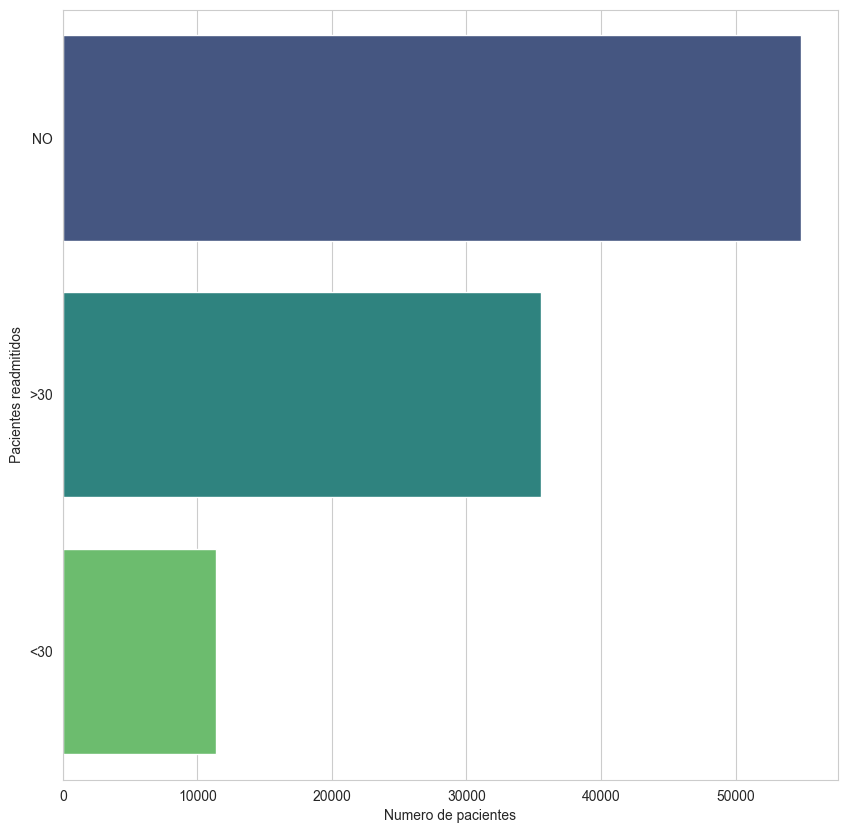

Porcentajes de cada variable: readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


In [11]:
# Graficaré para tener una representación visual de la distribución.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid") # Tema para todos los graficos.
plt.figure(figsize=(10,10))
sns.countplot(data['readmitted'], color='blue', palette='viridis')
plt.xlabel('Numero de pacientes')
plt.ylabel('Pacientes readmitidos')
plt.show()

readmitted_norm = data['readmitted'].value_counts(normalize=True)
print(f"Porcentajes de cada variable: {readmitted_norm*100}")

Se puede observar una distribución desbalanceada, con un sesgo hacia los pacientes que no fueron readmitidos.
- mayor 30:  esta variable la manejaremos como pacientes que no fueron readmitidos y representa el 35.3%.
- NO: Pacientes que no fueron readmitidos y representa el 53.3%.
- Menor a 30: Aquellos que fueron readmitidos y representa el 11.2%.

- Para este analisis voy a optar por una clasificacion binaria, simplificando las variables mayor a 30 y NO como pacientes que no fueron readmitido, de esta manera la clase minoritaria es los pacientes que fueron readmitdos.
- De este modo creare una nueva columna llamada target que sera la variable objetivo y la dividire en dos grupos:
- 1: Aquellos que fueron readmitidos (<30 )
- 0: Aquellos que no fueron readmitidos (>30) Dias y (NO)

In [12]:
data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment
0,Caucasian,Female,[0-10),6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,No,NO,Otherwise
1,Caucasian,Female,[10-20),1,7,3,NaN,59,0,18,...,Up,No,No,No,No,No,Ch,Yes,>30,Discharged to home
2,AfricanAmerican,Female,[20-30),1,7,2,NaN,11,5,13,...,No,No,No,No,No,No,No,Yes,NO,Discharged to home
3,Caucasian,Male,[30-40),1,7,2,NaN,44,1,16,...,Up,No,No,No,No,No,Ch,Yes,NO,Discharged to home
4,Caucasian,Male,[40-50),1,7,1,NaN,51,0,8,...,Steady,No,No,No,No,No,Ch,Yes,NO,Discharged to home


In [13]:
mapping = {'<30': 1, '>30': 0, 'NO': 0}
data['target'] = data['readmitted'].map(mapping)

data['target'].value_counts()

target
0    90409
1    11357
Name: count, dtype: int64

- Pasaré las edades a numeros enteros ya que estan como rangos de edad, es decir 0-10, 10-20, etc.
- En este script voy a organizar las edades segun la media del rango de edad, de esta manera el modelo puede trabajar con enteros.


In [14]:
# Convertimos '[0-10)' en 5, '[10-20)' en 15, etc.
data['age'] = data['age'].str.strip()
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, 
    '[80-90)': 85, '[90-100)': 95
}
data['age'] = data['age'].map(age_mapping)

data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_segment,target
0,Caucasian,Female,5,6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,NO,Otherwise,0
1,Caucasian,Female,15,1,7,3,NaN,59,0,18,...,No,No,No,No,No,Ch,Yes,>30,Discharged to home,0
2,AfricanAmerican,Female,25,1,7,2,NaN,11,5,13,...,No,No,No,No,No,No,Yes,NO,Discharged to home,0
3,Caucasian,Male,35,1,7,2,NaN,44,1,16,...,No,No,No,No,No,Ch,Yes,NO,Discharged to home,0
4,Caucasian,Male,45,1,7,1,NaN,51,0,8,...,No,No,No,No,No,Ch,Yes,NO,Discharged to home,0


Estas dos columnas son características de resumen o agregadas. 
En lugar de describir el estado de un medicamento, describen el estado del tratamiento completo del paciente desde dos perspectivas diferentes.

In [15]:
# Defino los medicamentos que se obtuvieron desde la informacion del data set, en total 24 medicamentos
med_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'sitagliptin', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

# Corroboración: Verificamos que todas las columnas de la lista existan en el DataFrame.
existing_med_cols = [col for col in med_cols if col in data.columns]
missing_cols = [col for col in med_cols if col not in data.columns]

if missing_cols:
    print(f"Las siguientes columnas no se encontraron y serán ignoradas: {missing_cols}\n")

print(f"Se encontraron {len(existing_med_cols)} columnas de medicamentos.\n")






Las siguientes columnas no se encontraron y serán ignoradas: ['sitagliptin']

Se encontraron 22 columnas de medicamentos.



Genero caracteristicas para determinar si un paciente tuvo cambio en sus medicamentos respetando la siguiente jerarquia:
1. No
2. Steady
3. Cambio

In [16]:
# CREAR CARACTERÍSTICAS DE RESUMEN 

# Característica 1: Número de cambios en la dosis ('Up' o 'Down')
change_values = ['Up', 'Down']
data['numchange'] = data[existing_med_cols].isin(change_values).sum(axis=1)

# Característica 2: Número total de medicamentos que toma el paciente (cualquier estado que no sea 'No')
taking_med_values = ['Steady', 'Up', 'Down']
data['nummeds'] = data[existing_med_cols].isin(taking_med_values).sum(axis=1)

print(" DataFrame con Características de Resumen ('numchange' y 'nummeds')")
print(data[['numchange', 'nummeds']].head(15))
print("\n")
print(f" Valores unicos por columna \n{data[['numchange', 'nummeds']].nunique()}")


 DataFrame con Características de Resumen ('numchange' y 'nummeds')
    numchange  nummeds
0           0        0
1           1        1
2           0        1
3           1        1
4           0        2
5           0        1
6           0        3
7           0        1
8           0        2
9           0        2
10          0        1
11          1        2
12          2        3
13          0        1
14          0        1


 Valores unicos por columna 
numchange    5
nummeds      7
dtype: int64


- **numchange: La Intensidad del Ajuste del Tratamiento**
- ¿Qué Mide?: El número de medicamentos cuya dosis fue cambiada (subida o bajada) durante la visita.
- Cálculo: Es la suma de cuántas veces aparece 'Up' o 'Down' en las columnas de medicamentos para un paciente.
- Jerarquía y Significado: La jerarquía aquí es real y muy significativa. Representa el nivel de intervención médica.
- numchange = 0: Paciente Estable. No se le ajustó la dosis de ningún medicamento. Es el estado de menor intervención.
- numchange = 1: Ajuste Menor. Se le ajustó la dosis de un solo medicamento.
- numchange = 2: Ajuste Moderado. Se le ajustaron dos medicamentos.
- numchange = 3: Ajuste Significativo.
- numchange = 4 o más: Ajuste Agresivo. El equipo médico está haciendo cambios importantes en el tratamiento.
- Jerarquía de numchange: 4 > 3 > 2 > 1 > 0 Un valor más alto indica una intervención médica más intensa. Para un modelo que intenta predecir, por ejemplo, una readmisión hospitalaria, un numchange alto podría ser una señal de alerta muy potente de que el paciente está en una condición inestable.


- nummeds: La Complejidad del Tratamiento
- ¿Qué Mide?: El número total de medicamentos diferentes que un paciente está tomando (sin importar si la dosis es estable o se está ajustando).
- Cálculo: Es la suma de cuántas veces aparece 'Steady', 'Up' o 'Down' (es decir, cualquier cosa que no sea 'No').
- Jerarquía y Significado: La jerarquía aquí también es real y útil. Representa la complejidad o "carga" del régimen de medicación del paciente.
- nummeds = 0: Sin Medicación. El paciente no toma ninguno de los medicamentos de la lista.
- nummeds = 1: Manejo Simple. El paciente está en monoterapia (un solo medicamento).
- nummeds = 2: Terapia Dual.
- nummeds = 3 o más: Polifarmacia. El paciente está tomando múltiples medicamentos, lo que puede indicar una condición más difícil de manejar o comorbilidades.
- Jerarquía de nummeds: 4 > 3 > 2 > 1 > 0 Un valor más alto indica que el paciente tiene un esquema de medicación más complejo. Esto puede correlacionarse con la gravedad de la enfermedad o la duración de la misma.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  int64 
 3   admission_type_id         101766 non-null  int64 
 4   admission_source_id       101766 non-null  int64 
 5   time_in_hospital          101766 non-null  int64 
 6   medical_specialty         51817 non-null   object
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101745 non-null  object
 14  diag

- Ahora agrupare los diagnosticos en 9 categorias segun su codificacion icd9, al hacer este cambio el modelo no tratará de predecir cada diagnsotico segun su etiqueta icd9 que pueden ser miles y al hacer one hot codificación se crearán miles de variables.
- En su defecto las agrupare en 9 categorias:
    - 0: Diabetes Mellitus
    - 1: Hipertension
    - 2: Obesidad
    - 3: Cardiopatia
    - 4: Neumonía
    - 5: Infeccion
    - 6: Enfermedad renal
    - 7: Enfermedad gastrointestinal
    - 8: Enfermedad respiratoria
De esta manera el modelo no solo podrá predecir si el paciente tiene alguna de estas enfermedades si no que tambien cual es mas relevante para su reingreso.

In [18]:
import pandas as pd
import numpy as np

def map_icd9_to_category(code):
    """
    Transforma códigos ICD-9 a categorías generales.
    Maneja códigos numéricos, alfanuméricos (V, E) y valores nulos (?).
    """
    if code == '?' or pd.isna(code):
        return 'Other'
    
    try:
        # Si empieza con V o E, usualmente son factores suplementarios o externos
        if str(code).startswith('V') or str(code).startswith('E'):
            return 'Other'
        
        # Convertimos a float para manejar decimales
        code_num = float(code)
        
        # Rangos estándar de agrupación ICD-9
        if 390 <= code_num <= 459 or code_num == 785:
            return 'Circulatory'
        elif 460 <= code_num <= 519 or code_num == 786:
            return 'Respiratory'
        elif 520 <= code_num <= 579 or code_num == 787:
            return 'Digestive'
        elif 250 <= code_num < 251:
            return 'Diabetes'
        elif 800 <= code_num <= 999:
            return 'Injury'
        elif 710 <= code_num <= 739:
            return 'Musculoskeletal'
        elif 580 <= code_num <= 629 or code_num == 788:
            return 'Genitourinary'
        elif 140 <= code_num <= 239:
            return 'Neoplasms'
        else:
            return 'Other' # Incluye infecciosas, mentales, etc.
            
    except ValueError:
        return 'Other'

# Aplicamos la función a las 3 columnas de diagnóstico
diag_cols = ['diag_1', 'diag_2', 'diag_3']
for col in diag_cols:
    data[f'{col}_group'] = data[col].apply(map_icd9_to_category)

# Verificamos el resultado
print(data[['diag_1', 'diag_1_group']].head(15))

    diag_1 diag_1_group
0   250.83     Diabetes
1      276        Other
2      648        Other
3        8        Other
4      197    Neoplasms
5      414  Circulatory
6      414  Circulatory
7      428  Circulatory
8      398  Circulatory
9      434  Circulatory
10   250.7     Diabetes
11     157    Neoplasms
12     428  Circulatory
13     428  Circulatory
14     518  Respiratory


Nuevas columnas creadas para identificar los diagnosticos
- El cambio es pasar de una codificacion idc9 a una mas entendible con el nombre del diagnostico con respecto a la version de icd9 que se esta usando.
- De esta manera el modelo puede entender mejor los datos.

In [19]:
data.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)
print('Columnas eliminadas.')

Columnas eliminadas.


In [20]:
data.drop(columns=['readmitted'], inplace=True)
data.head()

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,metformin-pioglitazone,change,diabetesMed,discharge_segment,target,numchange,nummeds,diag_1_group,diag_2_group,diag_3_group
0,Caucasian,Female,5,6,1,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,Otherwise,0,0,0,Diabetes,Other,Other
1,Caucasian,Female,15,1,7,3,NaN,59,0,18,...,No,Ch,Yes,Discharged to home,0,1,1,Other,Diabetes,Other
2,AfricanAmerican,Female,25,1,7,2,NaN,11,5,13,...,No,No,Yes,Discharged to home,0,0,1,Other,Diabetes,Other
3,Caucasian,Male,35,1,7,2,NaN,44,1,16,...,No,Ch,Yes,Discharged to home,0,1,1,Other,Diabetes,Circulatory
4,Caucasian,Male,45,1,7,1,NaN,51,0,8,...,No,Ch,Yes,Discharged to home,0,0,2,Neoplasms,Neoplasms,Diabetes


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

X = data.drop('target', axis=1)
y = data['target']

# Agregar logica 
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Crear el transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
)



In [22]:
import pickle
model_columns = list(X.columns)
pickle.dump(model_columns, open("../models/model_columns.pkl", "wb"))

Creo un flujo Pipeline para XGBoost para evitar fuga de datos y que aplique standarscaler a variables numericas y OneHotEncoder a variables categoricas.


In [23]:
# Encadenamos el preprocesador y el modelo en un solo objeto.
# El pipeline se encargará de aplicar cada paso en orden.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Entrenamos el pipeline
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:,1]





### Evaluar rendimiento del modelo utilizando metricas


Accuracy: 0.8874

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27123
           1       0.41      0.02      0.04      3407

    accuracy                           0.89     30530
   macro avg       0.65      0.51      0.49     30530
weighted avg       0.84      0.89      0.84     30530


AUC: 0.5086

Confusion Matrix:
[[27022   101]
 [ 3336    71]]


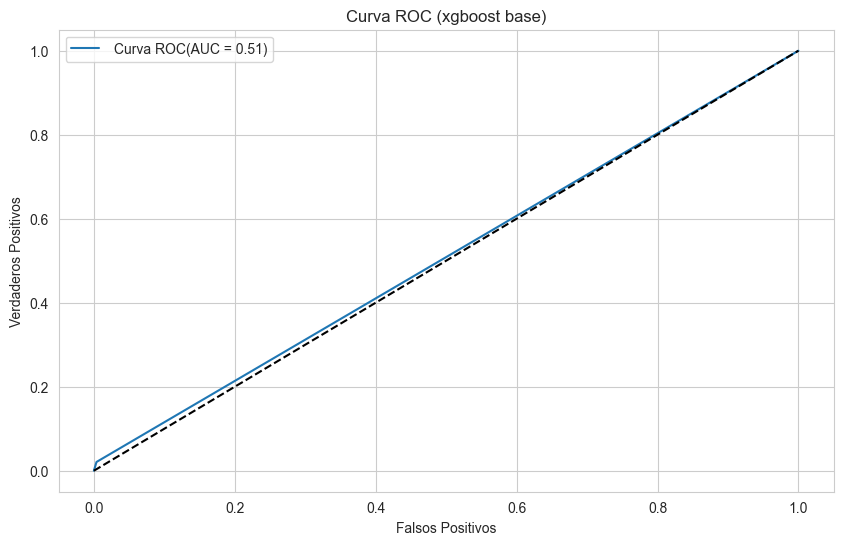

In [24]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_pred)
print(f"\nAUC: {auc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f' Curva ROC(AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC (xgboost base)')
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.5085578356632762


In [26]:
# Pasos del Pipeline
print("\nPasos del Pipeline:")
model_pipeline.steps


Pasos del Pipeline:


[('preprocessor',
  ColumnTransformer(transformers=[('num', StandardScaler(),
                                   Index(['age', 'admission_type_id', 'admission_source_id', 'time_in_hospital',
         'num_lab_procedures', 'num_procedures', 'num_medications',
         'number_outpatient', 'number_emergency', 'number_inpatient',
         'number_diagnoses', 'numchange', 'nummeds'],
        dtype='object')),
                                  ('cat', OneHotEncoder(handle_unknown='ignore'),
                                   I...
         'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
         'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
         'tolazamide', 'examide', 'citoglipton', 'insulin',
         'glyburide-metformin', 'glipizide-metformin',
         'glimepiride-pioglitazone', 'metformin-rosiglitazone',
         'metformin-pioglitazone', 'change', 'diabetesMed', 'discharge_segment',
         'diag_1_group', 'diag_2_group', 'dia


Accuracy: 0.8874

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27123
           1       0.41      0.02      0.04      3407

    accuracy                           0.89     30530
   macro avg       0.65      0.51      0.49     30530
weighted avg       0.84      0.89      0.84     30530


AUC: 0.6429

Confusion Matrix:
[[27022   101]
 [ 3336    71]]


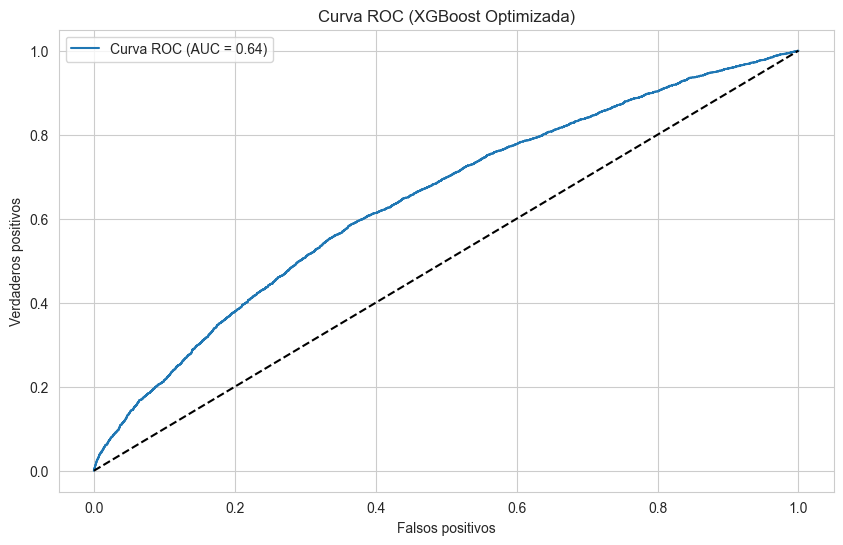

In [27]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC: {auc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC (XGBoost Optimizada)')
plt.legend()
plt.show()

In [28]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    """
    Función objetivo para optimizar los hiperparámetros de XGBoost dentro de un Pipeline.
    """
    
    # Definir el espacio de búsqueda de hiperparámetros
    # Usamos el prefijo 'classifier__' porque el modelo está dentro de un Pipeline llamado 'classifier'
    param_grid = {
        'classifier__n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'classifier__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'classifier__max_depth': trial.suggest_int('max_depth', 3, 10),
        'classifier__min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'classifier__gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'classifier__subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'classifier__colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'classifier__reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'classifier__reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        # Importante para data desbalanceada (scale_pos_weight)
        # Se suele calcular como: (total_negativos / total_positivos)
        # 'classifier__scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0) 
    }

    # Actualizar los parámetros del Pipeline existente
    model_pipeline.set_params(**param_grid)

    # Evaluación con Validación Cruzada (Cross-Validation)
    # cv=5 lo cambie a 5 para probar mejor robustez
    cv_scores = cross_val_score(
        model_pipeline, 
        X_train, 
        y_train, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1
    )

    # Retornar el promedio de los scores (Optuna intentará maximizar esto)
    return cv_scores.mean()

In [29]:
# Crear el estudio
study = optuna.create_study(direction='maximize', study_name='xgboost_optimization')

# Iniciar la optimización (esto puede tardar unos minutos dependiendo de tu hardware)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("-" * 50)
print("¡Optimización terminada!")
print(f"Mejor AUC ROC obtenido: {study.best_value:.4f}")
print("Mejores Hiperparámetros encontrados:")
print(study.best_params)

[I 2025-11-28 19:49:06,123] A new study created in memory with name: xgboost_optimization


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-28 19:49:13,390] Trial 0 finished with value: 0.6530768934533138 and parameters: {'n_estimators': 749, 'learning_rate': 0.04902500245267124, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 4.080372317572134, 'subsample': 0.9753744945303404, 'colsample_bytree': 0.655455478500542, 'reg_alpha': 1.0875766536698343e-05, 'reg_lambda': 0.009066697916342003}. Best is trial 0 with value: 0.6530768934533138.
[I 2025-11-28 19:49:23,955] Trial 1 finished with value: 0.6474258010563314 and parameters: {'n_estimators': 784, 'learning_rate': 0.027825729479710917, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 2.1097013681493104, 'subsample': 0.5358320151193942, 'colsample_bytree': 0.6840615464842009, 'reg_alpha': 0.009626552879013801, 'reg_lambda': 1.0901105950580235e-05}. Best is trial 0 with value: 0.6530768934533138.
[I 2025-11-28 19:49:31,864] Trial 2 finished with value: 0.6547203056472284 and parameters: {'n_estimators': 823, 'learning_rate': 0.037998639456769095, 'max_depth': 3, 'm

In [30]:
# 1. Obtener los mejores parámetros del estudio
best_params = study.best_params

# 2. Ajustar las claves del diccionario para que coincidan con el Pipeline
# (Añadimos el prefijo 'classifier__' a cada clave que nos dio Optuna)
pipeline_params = {f'classifier__{k}': v for k, v in best_params.items()}

# 3. Configurar el pipeline con los ganadores
model_pipeline.set_params(**pipeline_params)

# 4. Entrenar modelo definitivo
model_pipeline.fit(X_train, y_train)

# 5. Generar predicciones
# predict() nos da clases (0 o 1)
y_pred = model_pipeline.predict(X_test)
# predict_proba() nos da la probabilidad (0.0 a 1.0), necesaria para el AUC y la curva ROC
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("Modelo entrenado y predicciones generadas.")

Modelo entrenado y predicciones generadas.


### Evaluar el modelo final xgboost con optimización de hiperparámetros usando optuna

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Métricas Numéricas
auc_final = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"AUC ROC Final (Test Set): {auc_final:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

AUC ROC Final (Test Set): 0.6587
Accuracy: 0.8888

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     27123
           1       0.63      0.01      0.02      3407

    accuracy                           0.89     30530
   macro avg       0.76      0.50      0.48     30530
weighted avg       0.86      0.89      0.84     30530



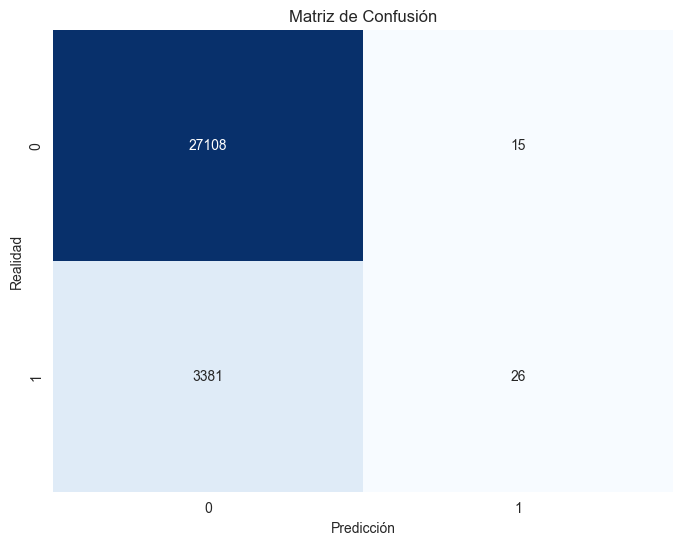

In [32]:
# Visualización: Matriz de Confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.savefig('../reports/figures/matriz_confusion.png')
plt.show()


In [33]:
# --- Visualización: Importancia de los Hiperparámetros (Optuna) ---
print("¿Qué hiperparámetros importaron más?")
optuna.visualization.plot_param_importances(study)
plt.show()

¿Qué hiperparámetros importaron más?


CURVA ROC

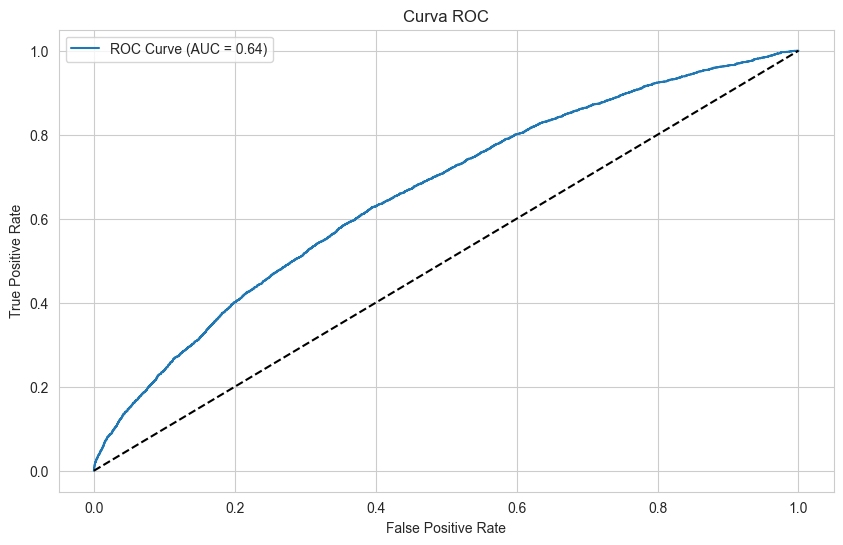

In [34]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.savefig('../reports/figures/roc_curve.png')
plt.show()

Características más Importantes (por Ganancia/Gain
                                  feature  importance
9                        number_inpatient    0.056118
174           discharge_segment_Otherwise    0.040458
173  discharge_segment_Discharged to home    0.032830
8                        number_emergency    0.016710
190                diag_2_group_Neoplasms    0.011027
171                        diabetesMed_No    0.010162
10                       number_diagnoses    0.009676
153                          insulin_Down    0.009438
176                 diag_1_group_Diabetes    0.009176
154                            insulin_No    0.009151


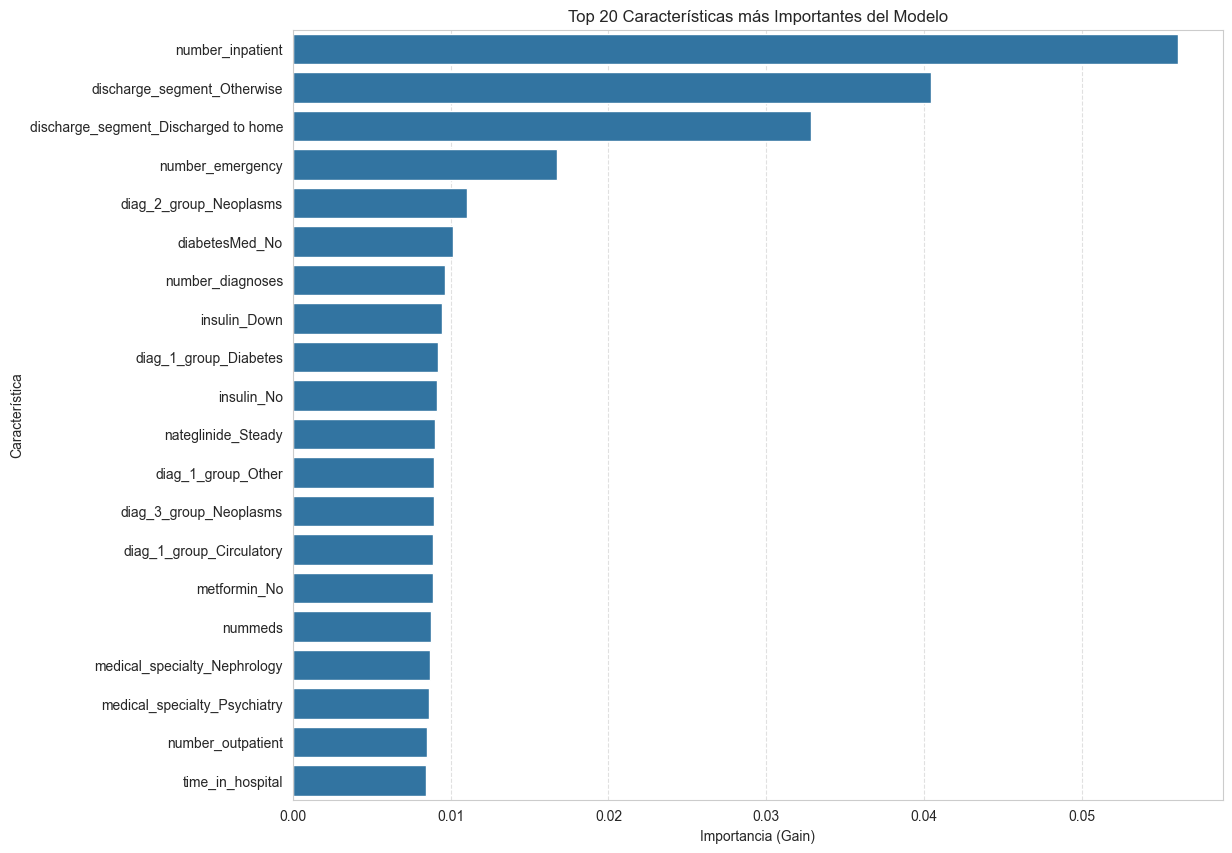

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Acceder al modelo entrenado DENTRO del pipeline
# Usamos .named_steps para obtener el paso 'classifier' por su nombre.
trained_model = model_pipeline.named_steps['classifier']
importances = trained_model.feature_importances_

#  Obtener los nombres de las características finales
# Accedemos al preprocesador para que nos dé los nombres de las columnas que generó.
preprocessor = model_pipeline.named_steps['preprocessor']

# Nombres de las columnas numéricas (no cambian)
num_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out()

# Nombres de las columnas categóricas (generadas por OneHotEncoder)
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Combinamos los nombres en el orden correcto
final_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Se crea data frame que contiene las variables y sus importancias
df_imp = pd.DataFrame({
    "feature": final_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Visualizar los resultados
print("Características más Importantes (por Ganancia/Gain")
print(df_imp.head(10))

# Graficar para una mejor interpretación
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=df_imp.head(20))
plt.title('Top 20 Características más Importantes del Modelo')
plt.xlabel('Importancia (Gain)')
plt.ylabel('Característica')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [36]:
import plotly.express as px
import numpy as np

# Asumiendo que df_imp es tu DataFrame con las columnas 'feature' e 'importance'

# Importancia de las características
fig_imp = px.bar(df_imp.head(20), 
                 x='importance', 
                 y='feature', 
                 orientation='h',
                 title='<b>Top 20 Variables más Influyentes (XGBoost)</b>',
                 color='importance',
                 color_continuous_scale='Viridis',
                 text_auto='.4f',
                 labels={'importance': 'Importancia', 'feature': 'Característica'}) # Usamos labels para las etiquetas del gráfico
fig_imp.write_image("../reports/figures/feature_importance_xgboost.png")

fig_imp.update_layout(yaxis={'categoryorder': 'total ascending'}, height=800)


fig_imp.show()



Shap



In [37]:
# MATRIZ DE CONFUSIÓN
cm = confusion_matrix(y_test, y_pred)
# Convertimos a texto para mostrar en el heatmap
z_text = [[str(y) for y in x] for x in cm]

fig_cm = px.imshow(cm, 
                   text_auto=True,
                   aspect="auto",
                   labels=dict(x="Predicción", y="Realidad", color="Cantidad"),
                   x=['No Readmitido (0)', 'Readmitido (1)'],
                   y=['No Readmitido (0)', 'Readmitido (1)'],
                   color_continuous_scale='Blues',
                   title="<b>Matriz de Confusión Interactiva</b>")
fig_imp.write_image("../reports/figures/confusion_matrix_xgboost.png")
fig_cm.show()





In [38]:
# CURVA ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

fig_roc = px.area(
    x=fpr, y=tpr,
    title=f'<b>Curva ROC (AUC = {auc_score:.4f})</b>',
    labels=dict(x='Tasa de Falsos Positivos (FPR)', y='Tasa de Verdaderos Positivos (TPR)'),
    width=700, height=600
)
fig_roc.add_shape(
    type='line', line=dict(dash='dash', color='grey'),
    x0=0, x1=1, y0=0, y1=1
)
fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
fig_roc.write_image("../reports/figures/roc_curve_xgboost.png")
fig_roc.show()

In [39]:
# distribución de las probabilidades (Separación de Clases)
# Creamos un DF temporal para graficar
df_prob = pd.DataFrame({'Probabilidad': y_pred_proba, 'Clase Real': y_test})
df_prob['Clase Real'] = df_prob['Clase Real'].map({0: '0 - No Readmitido', 1: '1 - Readmitido'})

fig_hist = px.histogram(df_prob, 
                        x="Probabilidad", 
                        color="Clase Real", 
                        nbins=50,
                        title="<b>Distribución de Probabilidades Predichas por Clase Real</b>",
                        marginal="box", # Muestra boxplots arriba para ver outliers
                        opacity=0.6,
                        barmode='overlay', # Superponer para comparar
                        color_discrete_map={'0 - No Readmitido': '#636EFA', '1 - Readmitido': '#EF553B'})
fig_hist.write_image("../reports/figures/distribucion_probabilidades.png")
fig_hist.update_layout(xaxis_title="Probabilidad asignada por el modelo (de ser Clase 1)")
fig_hist.show()

### Guardado de modelo
- Para produccir guardare el modelo por columnas y el modelo total.


In [40]:
import pickle
pickle.dump(model_pipeline, open("../models/modelo_optuna.pkl", "wb"))

Entrenando modelo con las 10 características más importantes según el modelo XGBoost.

Estas características son basadas en los datos en crudo, al generar el one hot encoding se generan las que el modelo toma de importancia.

In [41]:
data.head()
data.to_csv("../data/processed/data.csv", index=False)

In [42]:
TOP_10_FEATURES = [
    'number_inpatient',      # Most important
    'discharge_segment',     # Generó las vars 2 y 3 más importantes
    'number_emergency',      # Visitas de emergencia
    'diag_1_group',          # Diagnóstico primario (Circulatory/Resp/Diabetes)
    'diag_2_group',          # Diagnóstico secundario
    'diabetesMed',           # Indicador general de medicación
    'insulin',               # Insulina (Se redujo la dosis de insulina)
    'number_diagnoses',      # Cantidad de diagnósticos
    'age',                   # Edad 
    'time_in_hospital'       # Tiempo en hospital
]
data_top_10 = data[TOP_10_FEATURES + ['target']]
data_top_10.head()

,number_inpatient,discharge_segment,number_emergency,diag_1_group,diag_2_group,diabetesMed,insulin,number_diagnoses,age,time_in_hospital,target
0,0,Otherwise,0,Diabetes,Other,No,No,1,5,1,0
1,0,Discharged to home,0,Other,Diabetes,Yes,Up,9,15,3,0
2,1,Discharged to home,0,Other,Diabetes,Yes,No,6,25,2,0
3,0,Discharged to home,0,Other,Diabetes,Yes,Up,7,35,2,0
4,0,Discharged to home,0,Neoplasms,Neoplasms,Yes,Steady,5,45,1,0


In [43]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np

X = data_top_10.drop(columns=['target'])
y = data_top_10['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipeline_10 = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

pipeline_10.fit(X_train, y_train)

y_pred = pipeline_10.predict(X_test)
y_pred_proba = pipeline_10.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))



              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.41      0.02      0.03      2285

    accuracy                           0.89     20354
   macro avg       0.65      0.51      0.49     20354
weighted avg       0.84      0.89      0.84     20354

ROC AUC Score: 0.6440779467669097


c:\Users\asjer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:02:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Optimización de hiperparámetros con Optuna 

In [44]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    """
    Función objetivo para optimizar los hiperparámetros de XGBoost dentro de un Pipeline.
    """
    
    # Definir el espacio de búsqueda de hiperparámetros
    # Usamos el prefijo 'xgb__' porque el modelo está dentro de un Pipeline llamado 'xgb'
    param_grid = {
    'xgb__n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    'xgb__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    'xgb__max_depth': trial.suggest_int('max_depth', 3, 10),
    'xgb__min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'xgb__gamma': trial.suggest_float('gamma', 0, 5),
    'xgb__subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'xgb__colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'xgb__reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1.0),
    'xgb__reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1.0)
}

        # Importante para data desbalanceada (scale_pos_weight)
        # Se suele calcular como: (total_negativos / total_positivos)
        # 'classifier__scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0) 
    

    # Actualizar los parámetros del Pipeline existente
    pipeline_10.set_params(**param_grid)

    # Evaluación con Validación Cruzada (Cross-Validation)
    # cv=5 lo cambie a 5 para probar mejor robustez
    cv_scores = cross_val_score(
        pipeline_10, 
        X_train, 
        y_train, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1
    )

    # Retornar el promedio de los scores (Optuna intentará maximizar esto)
    return cv_scores.mean()

In [45]:
# Crear el estudio
study = optuna.create_study(direction='maximize', study_name='xgboost_optimization_10')

# Iniciar la optimización (esto puede tardar unos minutos dependiendo de tu hardware)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("-" * 50)
print("¡Optimización terminada!")
print(f"Mejor AUC ROC obtenido: {study.best_value:.4f}")
print("Mejores Hiperparámetros encontrados:")
print(study.best_params)

[I 2025-11-28 20:02:29,813] A new study created in memory with name: xgboost_optimization_10


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:02:32,248] Trial 0 finished with value: 0.6503863902600852 and parameters: {'n_estimators': 344, 'learning_rate': 0.1663636169245303, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 3.4415802050185245, 'subsample': 0.6353263277327479, 'colsample_bytree': 0.9418681166474994, 'reg_alpha': 0.004058809291401558, 'reg_lambda': 0.03364552331715555}. Best is trial 0 with value: 0.6503863902600852.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:02:33,779] Trial 1 finished with value: 0.651198892459065 and parameters: {'n_estimators': 140, 'learning_rate': 0.12766633893635457, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.4840539781608788, 'subsample': 0.8591864784951989, 'colsample_bytree': 0.500817355392105, 'reg_alpha': 0.6024402321503902, 'reg_lambda': 0.022701505632485887}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:02:44,466] Trial 2 finished with value: 0.6157358178722634 and parameters: {'n_estimators': 991, 'learning_rate': 0.03603384982918147, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.3025030287697722, 'subsample': 0.6780289369859206, 'colsample_bytree': 0.5227343797306648, 'reg_alpha': 5.472090549899924e-05, 'reg_lambda': 0.010615963430411648}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:02:47,960] Trial 3 finished with value: 0.6163012362835204 and parameters: {'n_estimators': 489, 'learning_rate': 0.2682616251035183, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 1.9925823790657438, 'subsample': 0.5589826600463977, 'colsample_bytree': 0.6925044937706637, 'reg_alpha': 0.0021151762142343823, 'reg_lambda': 0.3751111931666385}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:02:52,318] Trial 4 finished with value: 0.6502393196122263 and parameters: {'n_estimators': 810, 'learning_rate': 0.2442825773591289, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 4.211839429918519, 'subsample': 0.8280452337200255, 'colsample_bytree': 0.9007068270623899, 'reg_alpha': 0.0008346673860496068, 'reg_lambda': 0.24001632099585324}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:02:57,740] Trial 5 finished with value: 0.6452185363380539 and parameters: {'n_estimators': 921, 'learning_rate': 0.2617061375645438, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 2.8927300045782323, 'subsample': 0.5440850915342094, 'colsample_bytree': 0.681237003965258, 'reg_alpha': 6.683992067085761e-05, 'reg_lambda': 0.09787560703572874}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:00,626] Trial 6 finished with value: 0.6505170145601353 and parameters: {'n_estimators': 289, 'learning_rate': 0.07664999456347134, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 4.280956725665985, 'subsample': 0.819538567939859, 'colsample_bytree': 0.875892423284136, 'reg_alpha': 0.06992082024614725, 'reg_lambda': 7.312015757584692e-05}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:03,839] Trial 7 finished with value: 0.6511477905600387 and parameters: {'n_estimators': 529, 'learning_rate': 0.071143263547134, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 2.797474539683831, 'subsample': 0.9048554438052736, 'colsample_bytree': 0.7744156000972453, 'reg_alpha': 0.5497474007853363, 'reg_lambda': 0.01394087671208125}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:06,170] Trial 8 finished with value: 0.6479279843745338 and parameters: {'n_estimators': 353, 'learning_rate': 0.284477797797627, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 3.4988298561125286, 'subsample': 0.9639018728311151, 'colsample_bytree': 0.9604370692803006, 'reg_alpha': 0.03426779556046475, 'reg_lambda': 9.8163848636014e-05}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:08,346] Trial 9 finished with value: 0.6374764060790695 and parameters: {'n_estimators': 289, 'learning_rate': 0.1819576896269789, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 1.9195630246447082, 'subsample': 0.6982511685490427, 'colsample_bytree': 0.8371732317132283, 'reg_alpha': 0.025805029472880422, 'reg_lambda': 0.570094636445594}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:09,969] Trial 10 finished with value: 0.6484255690594211 and parameters: {'n_estimators': 149, 'learning_rate': 0.12104624342039963, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.10924256847877611, 'subsample': 0.7900792263405609, 'colsample_bytree': 0.5271412767375764, 'reg_alpha': 0.6388019621385485, 'reg_lambda': 0.001201594744264094}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:13,924] Trial 11 finished with value: 0.6502324353099873 and parameters: {'n_estimators': 666, 'learning_rate': 0.09257206492268685, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 1.0699995571244754, 'subsample': 0.9372988675592111, 'colsample_bytree': 0.762461869372816, 'reg_alpha': 0.9766953122038318, 'reg_lambda': 0.0017862461219112307}. Best is trial 1 with value: 0.651198892459065.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:15,541] Trial 12 finished with value: 0.6518194309798235 and parameters: {'n_estimators': 122, 'learning_rate': 0.03321826017576871, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 1.2517301336196898, 'subsample': 0.8902508904631243, 'colsample_bytree': 0.624889953845331, 'reg_alpha': 0.18857120864037039, 'reg_lambda': 0.009518539575216825}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:17,148] Trial 13 finished with value: 0.6516016998612899 and parameters: {'n_estimators': 118, 'learning_rate': 0.013354895541332568, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 1.0603572772049845, 'subsample': 0.8919643636015797, 'colsample_bytree': 0.6053636194561792, 'reg_alpha': 0.12555352727854774, 'reg_lambda': 0.00414288575877481}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:18,753] Trial 14 finished with value: 0.6517968479294 and parameters: {'n_estimators': 116, 'learning_rate': 0.02550797273275976, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 1.3345248617908672, 'subsample': 0.8925015285013506, 'colsample_bytree': 0.6230803898407693, 'reg_alpha': 0.07826783123765467, 'reg_lambda': 0.00041473121482945316}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:20,762] Trial 15 finished with value: 0.6511515441455732 and parameters: {'n_estimators': 224, 'learning_rate': 0.04039655890850137, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 1.5197025973506835, 'subsample': 0.9769623026681489, 'colsample_bytree': 0.6275174991191728, 'reg_alpha': 0.009220219845619576, 'reg_lambda': 1.4760451437499857e-05}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:23,955] Trial 16 finished with value: 0.6254575568818799 and parameters: {'n_estimators': 417, 'learning_rate': 0.2091418634641552, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.9648482789604055, 'subsample': 0.7538202115098355, 'colsample_bytree': 0.6023006793060318, 'reg_alpha': 0.13556330644960227, 'reg_lambda': 0.0004894608979771062}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:28,855] Trial 17 finished with value: 0.6509065997213787 and parameters: {'n_estimators': 645, 'learning_rate': 0.010373343516570675, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 2.0414759930119986, 'subsample': 0.9959160074676159, 'colsample_bytree': 0.6885556225396209, 'reg_alpha': 0.0004836449135253895, 'reg_lambda': 0.0003376952858624269}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:30,889] Trial 18 finished with value: 0.6507997310860748 and parameters: {'n_estimators': 237, 'learning_rate': 0.05296130490576004, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 1.4507168501015, 'subsample': 0.8920664100388246, 'colsample_bytree': 0.5905350843295173, 'reg_alpha': 0.01188834018099416, 'reg_lambda': 0.004346696019550125}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:32,551] Trial 19 finished with value: 0.6509557321124451 and parameters: {'n_estimators': 220, 'learning_rate': 0.11328911506951939, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 4.9182701362695616, 'subsample': 0.7611276673960535, 'colsample_bytree': 0.6449300092348217, 'reg_alpha': 1.3012176924772528e-05, 'reg_lambda': 1.0650820890199125e-05}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:35,683] Trial 20 finished with value: 0.6399915634916163 and parameters: {'n_estimators': 435, 'learning_rate': 0.14494580754124978, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.7015207105451015, 'subsample': 0.8545649396781714, 'colsample_bytree': 0.5693363946467427, 'reg_alpha': 0.20204920622494826, 'reg_lambda': 0.00017349381942962066}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:37,165] Trial 21 finished with value: 0.6504692465663041 and parameters: {'n_estimators': 105, 'learning_rate': 0.01017376753360419, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 1.3628795984562923, 'subsample': 0.9188758152467875, 'colsample_bytree': 0.7157831763931441, 'reg_alpha': 0.18747731980997018, 'reg_lambda': 0.006622160482101685}. Best is trial 12 with value: 0.6518194309798235.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:38,491] Trial 22 finished with value: 0.6518511251660691 and parameters: {'n_estimators': 101, 'learning_rate': 0.03334461702073747, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 2.4362511749799642, 'subsample': 0.8783226236369743, 'colsample_bytree': 0.55134927761957, 'reg_alpha': 0.08051504648043586, 'reg_lambda': 0.0012407103554150961}. Best is trial 22 with value: 0.6518511251660691.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:40,263] Trial 23 finished with value: 0.6521697189416306 and parameters: {'n_estimators': 201, 'learning_rate': 0.0539069960789932, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 2.5170294708163734, 'subsample': 0.8563069439141962, 'colsample_bytree': 0.5485830330957524, 'reg_alpha': 0.042532151591717325, 'reg_lambda': 0.0007718564359433439}. Best is trial 23 with value: 0.6521697189416306.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:42,046] Trial 24 finished with value: 0.6519433611734652 and parameters: {'n_estimators': 197, 'learning_rate': 0.06360616139858231, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 2.45853651474133, 'subsample': 0.8025453537643387, 'colsample_bytree': 0.5533010861612172, 'reg_alpha': 0.023944677351106277, 'reg_lambda': 0.001241759069457013}. Best is trial 23 with value: 0.6521697189416306.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:43,860] Trial 25 finished with value: 0.6513362076031883 and parameters: {'n_estimators': 204, 'learning_rate': 0.07299943994809413, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 2.4640290783732666, 'subsample': 0.7110129931944622, 'colsample_bytree': 0.5542265758237805, 'reg_alpha': 0.02318308319189296, 'reg_lambda': 0.0010057386048689164}. Best is trial 23 with value: 0.6521697189416306.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:46,724] Trial 26 finished with value: 0.6513560496138379 and parameters: {'n_estimators': 324, 'learning_rate': 0.09795947951694664, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 2.4526273248862873, 'subsample': 0.7926372462385176, 'colsample_bytree': 0.5439605107070223, 'reg_alpha': 0.007202057604758009, 'reg_lambda': 0.0017084957817443303}. Best is trial 23 with value: 0.6521697189416306.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:50,387] Trial 27 finished with value: 0.6521577333482748 and parameters: {'n_estimators': 612, 'learning_rate': 0.059456506307949915, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 3.194496735077598, 'subsample': 0.8373867595104578, 'colsample_bytree': 0.5673428274752148, 'reg_alpha': 0.043593073553088, 'reg_lambda': 2.8589707657940066e-05}. Best is trial 23 with value: 0.6521697189416306.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:54,212] Trial 28 finished with value: 0.6522041061563184 and parameters: {'n_estimators': 641, 'learning_rate': 0.0678690600460056, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 3.2745817049385084, 'subsample': 0.8239043014822393, 'colsample_bytree': 0.5024892776771275, 'reg_alpha': 0.03568887895624872, 'reg_lambda': 3.296759497746108e-05}. Best is trial 28 with value: 0.6522041061563184.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:03:57,925] Trial 29 finished with value: 0.6506182473452733 and parameters: {'n_estimators': 628, 'learning_rate': 0.15715143932855266, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 3.480324173763669, 'subsample': 0.628818710009143, 'colsample_bytree': 0.5023700624384375, 'reg_alpha': 0.005045159429617373, 'reg_lambda': 2.7053421352830756e-05}. Best is trial 28 with value: 0.6522041061563184.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:02,207] Trial 30 finished with value: 0.6508535274620707 and parameters: {'n_estimators': 729, 'learning_rate': 0.09291080309917735, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 3.068415383420077, 'subsample': 0.8520160103635845, 'colsample_bytree': 0.8101904757449224, 'reg_alpha': 0.002137087207635649, 'reg_lambda': 4.917955038610925e-05}. Best is trial 28 with value: 0.6522041061563184.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:05,712] Trial 31 finished with value: 0.6523131531709181 and parameters: {'n_estimators': 569, 'learning_rate': 0.062176637743983555, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 3.952655734743993, 'subsample': 0.7988321972543055, 'colsample_bytree': 0.5826331536091391, 'reg_alpha': 0.018645354873355793, 'reg_lambda': 0.00018235205505270794}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:09,546] Trial 32 finished with value: 0.6520030676793168 and parameters: {'n_estimators': 606, 'learning_rate': 0.05923521872161489, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 3.8693702578179323, 'subsample': 0.8431121824539095, 'colsample_bytree': 0.5855176093215079, 'reg_alpha': 0.04796435877496582, 'reg_lambda': 3.1857126852317716e-05}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:13,167] Trial 33 finished with value: 0.6519718389867594 and parameters: {'n_estimators': 560, 'learning_rate': 0.048071264754247625, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 3.2056727329961006, 'subsample': 0.7236967710348889, 'colsample_bytree': 0.6604004989634918, 'reg_alpha': 0.015316595636553824, 'reg_lambda': 0.00017421050537247277}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:17,403] Trial 34 finished with value: 0.6506456955978601 and parameters: {'n_estimators': 735, 'learning_rate': 0.1369332807039181, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 3.9866849652270426, 'subsample': 0.7637113795328665, 'colsample_bytree': 0.5028857808250589, 'reg_alpha': 0.0035562800112784857, 'reg_lambda': 0.00014118192301051404}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:21,559] Trial 35 finished with value: 0.6504129462702511 and parameters: {'n_estimators': 714, 'learning_rate': 0.10736280886874774, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 4.654541711523744, 'subsample': 0.6477150081794243, 'colsample_bytree': 0.5271843430074931, 'reg_alpha': 0.04814958310840801, 'reg_lambda': 2.4566431540008075e-05}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:26,310] Trial 36 finished with value: 0.6514265447445705 and parameters: {'n_estimators': 839, 'learning_rate': 0.0819189861625609, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 3.795761613144284, 'subsample': 0.8138480107632138, 'colsample_bytree': 0.7145060632895976, 'reg_alpha': 0.29575376948986276, 'reg_lambda': 6.59693382680289e-05}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:29,655] Trial 37 finished with value: 0.6478118660990082 and parameters: {'n_estimators': 577, 'learning_rate': 0.18804751542260434, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 3.6022441692090785, 'subsample': 0.7859462934720526, 'colsample_bytree': 0.9927370643505204, 'reg_alpha': 0.0011439144570327099, 'reg_lambda': 0.00028810037917161344}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:32,806] Trial 38 finished with value: 0.6522196271009284 and parameters: {'n_estimators': 487, 'learning_rate': 0.052653059147344625, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 3.1458530678434915, 'subsample': 0.8312376042513328, 'colsample_bytree': 0.5726813513278014, 'reg_alpha': 0.014695687667510905, 'reg_lambda': 4.43138810420911e-05}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:35,726] Trial 39 finished with value: 0.6520750016678847 and parameters: {'n_estimators': 480, 'learning_rate': 0.08267305426211277, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 2.877572421889138, 'subsample': 0.9362085239734382, 'colsample_bytree': 0.5221773886311194, 'reg_alpha': 0.013727394624984544, 'reg_lambda': 0.06052202540008406}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:40,394] Trial 40 finished with value: 0.651517629831964 and parameters: {'n_estimators': 800, 'learning_rate': 0.05001107926370741, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 4.410386316220316, 'subsample': 0.7360048717774188, 'colsample_bytree': 0.5766367311995245, 'reg_alpha': 0.0001954910360152988, 'reg_lambda': 0.0005808282183478272}. Best is trial 31 with value: 0.6523131531709181.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:44,820] Trial 41 finished with value: 0.6523698444265831 and parameters: {'n_estimators': 520, 'learning_rate': 0.061402261346462095, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 3.207193975929318, 'subsample': 0.8319485515299189, 'colsample_bytree': 0.567902700380731, 'reg_alpha': 0.006766161559894801, 'reg_lambda': 4.222599899523292e-05}. Best is trial 41 with value: 0.6523698444265831.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:48,668] Trial 42 finished with value: 0.6522046218236327 and parameters: {'n_estimators': 501, 'learning_rate': 0.024225566897862386, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 2.7314124493829275, 'subsample': 0.5056370509177617, 'colsample_bytree': 0.5263861976413576, 'reg_alpha': 0.005154409646053536, 'reg_lambda': 8.83172444292297e-05}. Best is trial 41 with value: 0.6523698444265831.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:52,221] Trial 43 finished with value: 0.6523287211695722 and parameters: {'n_estimators': 492, 'learning_rate': 0.02288431648365178, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 3.3049500063254396, 'subsample': 0.5542000376518648, 'colsample_bytree': 0.5205204864954955, 'reg_alpha': 0.002080326773700614, 'reg_lambda': 4.826875183391892e-05}. Best is trial 41 with value: 0.6523698444265831.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:56,136] Trial 44 finished with value: 0.6519881845317647 and parameters: {'n_estimators': 513, 'learning_rate': 0.025116041304197267, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 2.771257328317809, 'subsample': 0.5211247590587837, 'colsample_bytree': 0.6518148326830459, 'reg_alpha': 0.0012754743134692585, 'reg_lambda': 9.622158706641303e-05}. Best is trial 41 with value: 0.6523698444265831.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:04:59,301] Trial 45 finished with value: 0.6517910060209804 and parameters: {'n_estimators': 445, 'learning_rate': 0.026176657773943346, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 4.098299267634843, 'subsample': 0.5676078444576044, 'colsample_bytree': 0.5300182448717881, 'reg_alpha': 0.004930046736249436, 'reg_lambda': 5.930882048083357e-05}. Best is trial 41 with value: 0.6523698444265831.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:01,995] Trial 46 finished with value: 0.6521080194469817 and parameters: {'n_estimators': 376, 'learning_rate': 0.03836414259489362, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 3.698077911351678, 'subsample': 0.5880546972725014, 'colsample_bytree': 0.6089750115746793, 'reg_alpha': 0.000517574423184993, 'reg_lambda': 1.7041211638584704e-05}. Best is trial 41 with value: 0.6523698444265831.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:06,543] Trial 47 finished with value: 0.6524284148084037 and parameters: {'n_estimators': 484, 'learning_rate': 0.021337276399774802, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.9777166858849986, 'subsample': 0.5307440626787355, 'colsample_bytree': 0.5820284907561353, 'reg_alpha': 0.0021287183960708917, 'reg_lambda': 0.00011521510552087799}. Best is trial 47 with value: 0.6524284148084037.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:09,115] Trial 48 finished with value: 0.6483900422064488 and parameters: {'n_estimators': 391, 'learning_rate': 0.23753466245620727, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 3.383330331349092, 'subsample': 0.5929277921433163, 'colsample_bytree': 0.6706252912923055, 'reg_alpha': 0.0025319389782975776, 'reg_lambda': 0.0002447765187704649}. Best is trial 47 with value: 0.6524284148084037.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:12,430] Trial 49 finished with value: 0.6517920843067868 and parameters: {'n_estimators': 474, 'learning_rate': 0.04268084228887936, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 3.027705189414421, 'subsample': 0.5340551261984621, 'colsample_bytree': 0.629885141731697, 'reg_alpha': 0.0013492913948355751, 'reg_lambda': 0.00012251958260773405}. Best is trial 47 with value: 0.6524284148084037.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:16,589] Trial 50 finished with value: 0.6526151634924148 and parameters: {'n_estimators': 541, 'learning_rate': 0.019330823169337517, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 2.1333220176075995, 'subsample': 0.6911926632114557, 'colsample_bytree': 0.594315326093086, 'reg_alpha': 0.00023772968422995988, 'reg_lambda': 4.502916582605503e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:20,864] Trial 51 finished with value: 0.6517974292674829 and parameters: {'n_estimators': 543, 'learning_rate': 0.02233861379797001, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 1.786897682518778, 'subsample': 0.6701565578690688, 'colsample_bytree': 0.6058373314971364, 'reg_alpha': 0.000129597009036571, 'reg_lambda': 1.5088073092549288e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:24,907] Trial 52 finished with value: 0.6518203160509846 and parameters: {'n_estimators': 578, 'learning_rate': 0.04109796622061513, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 2.1625981145232256, 'subsample': 0.6251393863141562, 'colsample_bytree': 0.5878330455157418, 'reg_alpha': 3.121963325165407e-05, 'reg_lambda': 5.071575559769313e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:28,932] Trial 53 finished with value: 0.652432575079518 and parameters: {'n_estimators': 457, 'learning_rate': 0.015011139546306868, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 2.1641718982724343, 'subsample': 0.5650264199784413, 'colsample_bytree': 0.6349573427100194, 'reg_alpha': 0.0004863072323999445, 'reg_lambda': 4.293622983556227e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:32,390] Trial 54 finished with value: 0.6523075970674274 and parameters: {'n_estimators': 411, 'learning_rate': 0.020075962676150014, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 2.215045020950662, 'subsample': 0.5565594370048064, 'colsample_bytree': 0.6404224421454724, 'reg_alpha': 0.00038008329572661185, 'reg_lambda': 0.00019052588131613494}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:36,542] Trial 55 finished with value: 0.65236086778337 and parameters: {'n_estimators': 454, 'learning_rate': 0.010441328988448077, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 2.64016313283945, 'subsample': 0.5027248246622643, 'colsample_bytree': 0.7070577962657286, 'reg_alpha': 0.00024375541852445103, 'reg_lambda': 1.1523505330336742e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:41,253] Trial 56 finished with value: 0.6517385917604376 and parameters: {'n_estimators': 447, 'learning_rate': 0.010385155101261104, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 1.677970461198398, 'subsample': 0.5073637090607862, 'colsample_bytree': 0.7376785461657169, 'reg_alpha': 0.0002518134823946783, 'reg_lambda': 1.201032305072278e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:44,039] Trial 57 finished with value: 0.6512851661455373 and parameters: {'n_estimators': 332, 'learning_rate': 0.03264075878107213, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 2.237244268142132, 'subsample': 0.5987152130560788, 'colsample_bytree': 0.7028641081364461, 'reg_alpha': 9.440964118524242e-05, 'reg_lambda': 1.703947980307117e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:46,863] Trial 58 finished with value: 0.6517597811848644 and parameters: {'n_estimators': 289, 'learning_rate': 0.016972945537568986, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 2.709462176465316, 'subsample': 0.5358547932406393, 'colsample_bytree': 0.7887260179944389, 'reg_alpha': 0.0007160341262913311, 'reg_lambda': 2.1054133363524206e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:51,240] Trial 59 finished with value: 0.6476077801263429 and parameters: {'n_estimators': 533, 'learning_rate': 0.030005586245314513, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 1.895370639132754, 'subsample': 0.575044939661781, 'colsample_bytree': 0.9042673255200625, 'reg_alpha': 0.00024408550637457547, 'reg_lambda': 1.0362281467820964e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:53,721] Trial 60 finished with value: 0.641692206201155 and parameters: {'n_estimators': 365, 'learning_rate': 0.293451958605614, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 2.943768625172376, 'subsample': 0.5528881901306193, 'colsample_bytree': 0.6723169198395541, 'reg_alpha': 6.143958695190192e-05, 'reg_lambda': 4.450307987495612e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:05:58,674] Trial 61 finished with value: 0.6523836126069996 and parameters: {'n_estimators': 521, 'learning_rate': 0.04254288748288321, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.675962845729492, 'subsample': 0.6120163245581731, 'colsample_bytree': 0.6138263070809069, 'reg_alpha': 0.0006415427847813236, 'reg_lambda': 9.765861375927267e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:02,294] Trial 62 finished with value: 0.6519245759621339 and parameters: {'n_estimators': 510, 'learning_rate': 0.03762042853036463, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.585970140290317, 'subsample': 0.6078978694500998, 'colsample_bytree': 0.6100124707925153, 'reg_alpha': 0.0007545045664401003, 'reg_lambda': 9.157033896040711e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:05,961] Trial 63 finished with value: 0.6521887566165713 and parameters: {'n_estimators': 471, 'learning_rate': 0.018446819750948678, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.6491047473751257, 'subsample': 0.6792277093406552, 'colsample_bytree': 0.7474229661064123, 'reg_alpha': 0.0004593157551779798, 'reg_lambda': 3.765204394433843e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:09,855] Trial 64 finished with value: 0.6526026102212181 and parameters: {'n_estimators': 418, 'learning_rate': 0.010795425547999239, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 2.3345933127062626, 'subsample': 0.532188406054081, 'colsample_bytree': 0.5991845119175389, 'reg_alpha': 3.527742304945215e-05, 'reg_lambda': 7.812096717560248e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:13,703] Trial 65 finished with value: 0.6525955896881372 and parameters: {'n_estimators': 401, 'learning_rate': 0.0106681136985996, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 2.2964794319887387, 'subsample': 0.5231610344125804, 'colsample_bytree': 0.6249735559329569, 'reg_alpha': 4.104570567392786e-05, 'reg_lambda': 6.919542060104293e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:16,917] Trial 66 finished with value: 0.6503657355647515 and parameters: {'n_estimators': 416, 'learning_rate': 0.045103337083634745, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 2.2483522394198157, 'subsample': 0.524523894373303, 'colsample_bytree': 0.6187332479052307, 'reg_alpha': 3.1970052646224525e-05, 'reg_lambda': 0.00012236346405844597}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:21,629] Trial 67 finished with value: 0.6506547211005281 and parameters: {'n_estimators': 674, 'learning_rate': 0.03474228100103464, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 2.0299117141986045, 'subsample': 0.6161501995305886, 'colsample_bytree': 0.5952349743520619, 'reg_alpha': 4.654210083226025e-05, 'reg_lambda': 7.769124055879158e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:24,951] Trial 68 finished with value: 0.6510232983168196 and parameters: {'n_estimators': 401, 'learning_rate': 0.03052022217616139, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 1.574251649496221, 'subsample': 0.5805630192874658, 'colsample_bytree': 0.6374796122609145, 'reg_alpha': 1.2506403357847201e-05, 'reg_lambda': 0.2122926723218036}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:27,311] Trial 69 finished with value: 0.6502557310757193 and parameters: {'n_estimators': 306, 'learning_rate': 0.07265056324300508, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 1.8740212617062308, 'subsample': 0.6616910298153259, 'colsample_bytree': 0.5578257009223578, 'reg_alpha': 9.467375730777414e-05, 'reg_lambda': 0.0003494466393923081}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:30,702] Trial 70 finished with value: 0.6521254133121724 and parameters: {'n_estimators': 352, 'learning_rate': 0.013866114350937854, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.3394027751585016, 'subsample': 0.5215084933892808, 'colsample_bytree': 0.6599732501954121, 'reg_alpha': 4.08434123311478e-05, 'reg_lambda': 6.474332887352336e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:34,898] Trial 71 finished with value: 0.6521174661729854 and parameters: {'n_estimators': 447, 'learning_rate': 0.011144158531727748, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 2.098565672679347, 'subsample': 0.5091429006578683, 'colsample_bytree': 0.684417979879731, 'reg_alpha': 2.495348657369131e-05, 'reg_lambda': 2.326290353574346e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:39,119] Trial 72 finished with value: 0.6525401529977508 and parameters: {'n_estimators': 524, 'learning_rate': 0.018213102399533776, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 2.371564132223882, 'subsample': 0.5667442703650157, 'colsample_bytree': 0.6203078891964494, 'reg_alpha': 0.00014000984568114796, 'reg_lambda': 3.526780788132904e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:42,740] Trial 73 finished with value: 0.6513253312584343 and parameters: {'n_estimators': 520, 'learning_rate': 0.045015465037145444, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.3363516413278864, 'subsample': 0.5700317318409256, 'colsample_bytree': 0.6225119587305245, 'reg_alpha': 2.190963092214131e-05, 'reg_lambda': 0.01918560855442615}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:47,200] Trial 74 finished with value: 0.6462383090549372 and parameters: {'n_estimators': 589, 'learning_rate': 0.05577326863560948, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 1.7168335089067692, 'subsample': 0.538575504620994, 'colsample_bytree': 0.5661519154859269, 'reg_alpha': 0.0001336019837537719, 'reg_lambda': 0.00011725201176759326}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:51,076] Trial 75 finished with value: 0.6525292981541798 and parameters: {'n_estimators': 554, 'learning_rate': 0.0294702261812506, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 2.8837009411096357, 'subsample': 0.64343044488721, 'colsample_bytree': 0.5928362869305308, 'reg_alpha': 1.837874542462402e-05, 'reg_lambda': 3.549860487847556e-05}. Best is trial 50 with value: 0.6526151634924148.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:06:55,401] Trial 76 finished with value: 0.6530987762877649 and parameters: {'n_estimators': 605, 'learning_rate': 0.01924278182616511, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.8743152478610736, 'subsample': 0.6336000326168154, 'colsample_bytree': 0.5952032004770383, 'reg_alpha': 1.6650321262228918e-05, 'reg_lambda': 7.083364095071258e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:01,550] Trial 77 finished with value: 0.6527673984339297 and parameters: {'n_estimators': 663, 'learning_rate': 0.018723987002510968, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.8502104458938, 'subsample': 0.6802182901213122, 'colsample_bytree': 0.5944390738285058, 'reg_alpha': 1.6508017276949113e-05, 'reg_lambda': 3.29219799078567e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:06,029] Trial 78 finished with value: 0.6519805427169365 and parameters: {'n_estimators': 695, 'learning_rate': 0.03051804569886372, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.3809750228033235, 'subsample': 0.689243059552027, 'colsample_bytree': 0.5980315611527168, 'reg_alpha': 1.665560945468005e-05, 'reg_lambda': 3.2023605276372055e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:10,476] Trial 79 finished with value: 0.652677192382167 and parameters: {'n_estimators': 612, 'learning_rate': 0.019079377282816754, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.532904630957215, 'subsample': 0.6434176701363852, 'colsample_bytree': 0.6404914332392021, 'reg_alpha': 1.0702302300733955e-05, 'reg_lambda': 6.7330900471707e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:14,768] Trial 80 finished with value: 0.652585221572825 and parameters: {'n_estimators': 655, 'learning_rate': 0.028343972899644534, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.870112643437223, 'subsample': 0.6441184061294559, 'colsample_bytree': 0.6507597267639696, 'reg_alpha': 1.481158824522541e-05, 'reg_lambda': 0.00024721604868092455}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:19,229] Trial 81 finished with value: 0.6522675747268374 and parameters: {'n_estimators': 657, 'learning_rate': 0.028515174319455244, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.8400495489455415, 'subsample': 0.6461427199932208, 'colsample_bytree': 0.6475633771152062, 'reg_alpha': 1.0414916871130224e-05, 'reg_lambda': 6.227165312646643e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:23,563] Trial 82 finished with value: 0.6525299410609701 and parameters: {'n_estimators': 613, 'learning_rate': 0.018250071616653533, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.5897146320668836, 'subsample': 0.6396788983225186, 'colsample_bytree': 0.543146659525174, 'reg_alpha': 1.7392854659739934e-05, 'reg_lambda': 2.1565939817637936e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:28,068] Trial 83 finished with value: 0.6527618449923702 and parameters: {'n_estimators': 615, 'learning_rate': 0.01815297820286417, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.5779856279064406, 'subsample': 0.6992277461399637, 'colsample_bytree': 0.5363335343407303, 'reg_alpha': 1.5967841380486335e-05, 'reg_lambda': 2.081341380375512e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:32,942] Trial 84 finished with value: 0.6519518781191983 and parameters: {'n_estimators': 766, 'learning_rate': 0.03517289127095807, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 2.4578661235531785, 'subsample': 0.7194362466237381, 'colsample_bytree': 0.6258051087454193, 'reg_alpha': 3.1425664180959896e-05, 'reg_lambda': 0.00021358633493244513}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:37,825] Trial 85 finished with value: 0.652025374802088 and parameters: {'n_estimators': 688, 'learning_rate': 0.02008269701015716, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 1.9654178218089526, 'subsample': 0.6966222381015803, 'colsample_bytree': 0.5969163376668136, 'reg_alpha': 1.2560103550643815e-05, 'reg_lambda': 0.00014507970112779108}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:41,717] Trial 86 finished with value: 0.6522728848871905 and parameters: {'n_estimators': 631, 'learning_rate': 0.050410983391395894, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 3.072528133990401, 'subsample': 0.6736854344931474, 'colsample_bytree': 0.6623100010557016, 'reg_alpha': 3.9682342241721586e-05, 'reg_lambda': 7.821049915597645e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:45,242] Trial 87 finished with value: 0.649731835544958 and parameters: {'n_estimators': 607, 'learning_rate': 0.21737425694184234, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 2.548736015042037, 'subsample': 0.7423414804687659, 'colsample_bytree': 0.5398785244823089, 'reg_alpha': 7.809870503177557e-05, 'reg_lambda': 2.5782836729839646e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:50,640] Trial 88 finished with value: 0.6493116509649962 and parameters: {'n_estimators': 653, 'learning_rate': 0.16889379802509627, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.788395498167927, 'subsample': 0.6561622636947958, 'colsample_bytree': 0.6487216966309295, 'reg_alpha': 1.0167122665487381e-05, 'reg_lambda': 0.0004990923679566452}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:07:55,755] Trial 89 finished with value: 0.6524692096842803 and parameters: {'n_estimators': 751, 'learning_rate': 0.02461782375790299, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.291842544548985, 'subsample': 0.7084554473176267, 'colsample_bytree': 0.573304325415317, 'reg_alpha': 2.5386124196715507e-05, 'reg_lambda': 1.8028167810784746e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:00,255] Trial 90 finished with value: 0.6518759175795771 and parameters: {'n_estimators': 680, 'learning_rate': 0.038348110965323194, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 2.134972823998433, 'subsample': 0.6884947787311583, 'colsample_bytree': 0.5579383730701533, 'reg_alpha': 5.6831405191258725e-05, 'reg_lambda': 6.0328421349816585e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:04,754] Trial 91 finished with value: 0.6525559780743084 and parameters: {'n_estimators': 593, 'learning_rate': 0.017989407941560967, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.5393828553609072, 'subsample': 0.6309682064651625, 'colsample_bytree': 0.5391291528572832, 'reg_alpha': 1.6564932595617562e-05, 'reg_lambda': 2.4111647049448116e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:09,151] Trial 92 finished with value: 0.6525151668048818 and parameters: {'n_estimators': 585, 'learning_rate': 0.016301210987062168, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.5161395939204247, 'subsample': 0.6298569944233428, 'colsample_bytree': 0.616126273117813, 'reg_alpha': 1.5821084631799002e-05, 'reg_lambda': 0.002701272927412312}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:14,432] Trial 93 finished with value: 0.6527617857119161 and parameters: {'n_estimators': 706, 'learning_rate': 0.010783142398788352, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.3738371125915863, 'subsample': 0.6594408828332429, 'colsample_bytree': 0.5782237922187264, 'reg_alpha': 2.1971547220941138e-05, 'reg_lambda': 3.163421271848056e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:19,883] Trial 94 finished with value: 0.652463346043753 and parameters: {'n_estimators': 708, 'learning_rate': 0.010056464733619756, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 2.8050037035339, 'subsample': 0.6692964548839769, 'colsample_bytree': 0.5835676166114814, 'reg_alpha': 2.328503195822324e-05, 'reg_lambda': 2.8685838549796655e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:24,072] Trial 95 finished with value: 0.6520710042931099 and parameters: {'n_estimators': 622, 'learning_rate': 0.025412907750084503, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 3.0669779613646626, 'subsample': 0.6575401144590954, 'colsample_bytree': 0.5092798542161515, 'reg_alpha': 1.5041563661848376e-05, 'reg_lambda': 1.4971879617367347e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:27,985] Trial 96 finished with value: 0.6485005433451019 and parameters: {'n_estimators': 642, 'learning_rate': 0.12528280681524326, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 2.032345474005337, 'subsample': 0.7078156514808169, 'colsample_bytree': 0.5333383271140999, 'reg_alpha': 3.032686275650502e-05, 'reg_lambda': 2.052909760644675e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:33,012] Trial 97 finished with value: 0.6523170995827245 and parameters: {'n_estimators': 782, 'learning_rate': 0.03599270595956544, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.4868370237576816, 'subsample': 0.6241868617878406, 'colsample_bytree': 0.5532412232023821, 'reg_alpha': 1.9702044926140863e-05, 'reg_lambda': 5.096510927139115e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:38,338] Trial 98 finished with value: 0.6522765482294753 and parameters: {'n_estimators': 856, 'learning_rate': 0.023899459052165895, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 2.9423615694738374, 'subsample': 0.684106061348652, 'colsample_bytree': 0.5632666616794203, 'reg_alpha': 1.0013075230229998e-05, 'reg_lambda': 7.357557913612973e-05}. Best is trial 76 with value: 0.6530987762877649.


C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:19: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\asjer\AppData\Local\Temp\ipykernel_26768\2840193074.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[I 2025-11-28 20:08:42,660] Trial 99 finished with value: 0.6523434596281428 and parameters: {'n_estimators': 590, 'learning_rate': 0.016497238081954215, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 2.7086680831200685, 'subsample': 0.7349068815739436, 'colsample_bytree': 0.5794812239133122, 'reg_alpha': 4.690348938053985e-05, 'reg_lambda': 0.0001514636696033963}. Best is trial 76 with value: 0.6530987762877649.
--------------------------------------------------
¡Optimización terminada!
Mejor AUC ROC obtenido: 0.6531
Mejores Hiperparámetros encontrados:
{'n_estimators': 605, 'learning_rate': 0.01924278182616511, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.8743152478610736, 'subsample': 0.6336000326168154, 'colsample_bytree': 0.5952032004770383, 'reg_alpha': 1.6650321262228918e-05, 'reg_lambda': 7.083364095071258e-05}


In [46]:
# Obtener los mejores parámetros del estudio
best_params = study.best_params

# Ajustar las claves del diccionario para que coincidan con el Pipeline
# (Añadimos el prefijo 'xgboost__' a cada clave que nos dio Optuna)
pipeline_params = {f'xgb__{k}': v for k, v in best_params.items()}

# 3. Configurar el pipeline con los ganadores
pipeline_10.set_params(**pipeline_params)

# 4. Entrenar modelo definitivo
pipeline_10.fit(X_train, y_train)

# 5. Generar predicciones
# predict() nos da clases (0 o 1)
y_pred = pipeline_10.predict(X_test)
# predict_proba() nos da la probabilidad (0.0 a 1.0), necesaria para el AUC y la curva ROC
y_pred_proba = pipeline_10.predict_proba(X_test)[:, 1]

print("Modelo entrenado y predicciones generadas.")

c:\Users\asjer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:08:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado y predicciones generadas.


In [47]:

y_pred_proba = pipeline_10.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.59      0.01      0.02      2285

    accuracy                           0.89     20354
   macro avg       0.74      0.50      0.48     20354
weighted avg       0.86      0.89      0.84     20354

ROC AUC Score: 0.6592872835022277


In [48]:
import shap

# Inicializar JS para visualización
shap.initjs()

# Obtener el modelo y el preprocesador del pipeline
model = pipeline_10.named_steps['xgb']
preprocessor = pipeline_10.named_steps['preprocessor']

# Transformar los datos de prueba
# Nota: SHAP necesita los datos transformados (numéricos) para calcular los valores
X_test_transformed = preprocessor.transform(X_test)

# Obtener los nombres de las características transformadas
feature_names = preprocessor.get_feature_names_out()

# Crear el explainer
explainer = shap.TreeExplainer(model)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test_transformed)

# Generar el gráfico de resumen (beeswarm plot)
print("Gráfico SHAP (Summary Plot):")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

ValueError: could not convert string to float: '[1.114332E-1]'